# AlphaFold DB kinase dataset

So `kissim` can only reach the structurally covered kinome? Well, we are in luck! 

Let's use the predicted kinase structures provided in the AlphaFold DB (AF) and use these structures to generate a AF-based `kissim` tree.

In this notebook we prepare a kinase subset of the AF human dataset.

- Download the human AF dataset
- Get all kinase UniProt IDs in KLIFS (extract pseudokinases)
- Get all files in the human AF dataset
- Filter AF kinase structures (choose F1 models only)
- Decompress AF kinase files in new folder
- Aggreate and save AF-to-KLIFS metadata
- For fun: Show EGFR!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import tarfile
import re
import os

import pandas as pd
import nglview as nv

In [3]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data"

<div class="alert alert-block alert-info">
    <b>Manual step</b>: If you want to run this notebook with your copy of the AF dataset, please change the paths in the cell below to your paths.
</div>

In [4]:
# Path to AF download
AF_PATH = Path(DATA / "external/structures/AlphaFoldDB")
# Path to folder for processed output files from this notebook
AF_KLIFS_METADATA_PATH = DATA / "processed/af_klifs_metadata.csv"
# Path to folder for AF kinase PDB files (make this directory)
AF_KINASES_PATH = AF_PATH / "af_kinases"
AF_KINASES_PATH.mkdir(parents=True, exist_ok=True)

## Download the human AF dataset

<div class="alert alert-block alert-info">
    <b>Manual step</b>: AlphaFold DB provides for the proteome of different species. Download the human dataset!
</div>

https://alphafold.ebi.ac.uk/download

## Kinase UniProt IDs in KLIFS

Install the `opencadd` version that uses the KLIFS Swagger V2 (`klifs-dev` branch).

In [5]:
!pip install https://github.com/volkamerlab/opencadd/archive/klifs-dev.zip

  Using cached https://github.com/volkamerlab/opencadd/archive/klifs-dev.zip


In [6]:
from opencadd.databases.klifs import setup_remote

klifs_session = setup_remote()

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.
INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [7]:
# Get kinases in KLIFS
kinases = klifs_session.kinases.all_kinases(species="Human")
print(f"Number of kinases in KLIFS: {kinases.shape[0]}")
# Remove kinases without UniProt ID
kinases = kinases[kinases["kinase.uniprot"] != 0]
print(f"Number of kinases in KLIFS with UniProt ID: {kinases.shape[0]}")

Number of kinases in KLIFS: 555
Number of kinases in KLIFS with UniProt ID: 555


In [8]:
uniprot_ids = kinases["kinase.uniprot"].to_list()
len(uniprot_ids)

555

### Pseudokinases in KLIFS

These kinases might need to be dealt with individually, so let's keep a lot of UniProt IDs for downstream processing.

In [9]:
pseudokinases = kinases[kinases["kinase.klifs_name"].str.endswith("-b")]
uniprot_ids_pseudokinases = pseudokinases["kinase.uniprot"].to_list()
print(f"{len(uniprot_ids_pseudokinases)} pseudokinases")
kinases[kinases["kinase.uniprot"].isin(uniprot_ids_pseudokinases)]

13 pseudokinases


,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
133,306,GCN2,eukaryotic translation initiation factor 2 alp...,EIF2AK4,Q9P2K8,Human
134,307,GCN2-b,eukaryotic translation initiation factor 2 alp...,EIF2AK4-b,Q9P2K8,Human
201,435,JAK1,Janus kinase 1,JAK1,P23458,Human
202,438,JAK1-b,Janus kinase 1 (2nd domain),JAK1-b,P23458,Human
203,436,JAK2,Janus kinase 2,JAK2,O60674,Human
204,439,JAK2-b,Janus kinase 2 (2nd domain),JAK2-b,O60674,Human
205,437,JAK3,Janus kinase 3,JAK3,P52333,Human
206,440,JAK3-b,Janus kinase 3 (2nd domain),JAK3-b,P52333,Human
321,173,Obscn,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN,Q5VST9,Human
322,174,Obscn-b,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN-b,Q5VST9,Human


## Get all files in the human AF dataset

In [10]:
t = tarfile.open(Path(AF_PATH / "UP000005640_9606_HUMAN.tar"))
af_files = t.getnames()
len(af_files)

46782

In [11]:
af_files[:10]

['AF-A0A024R1R8-F1-model_v1.cif.gz',
 'AF-A0A024R1R8-F1-model_v1.pdb.gz',
 'AF-A0A024RBG1-F1-model_v1.cif.gz',
 'AF-A0A024RBG1-F1-model_v1.pdb.gz',
 'AF-A0A024RCN7-F1-model_v1.cif.gz',
 'AF-A0A024RCN7-F1-model_v1.pdb.gz',
 'AF-A0A075B6H5-F1-model_v1.cif.gz',
 'AF-A0A075B6H5-F1-model_v1.pdb.gz',
 'AF-A0A075B6H7-F1-model_v1.cif.gz',
 'AF-A0A075B6H7-F1-model_v1.pdb.gz']

## Filter AF kinase structures

In [12]:
uniprot_to_files = {}
for uniprot_id in uniprot_ids:
    r = re.compile(f".*{uniprot_id}.*.pdb.gz")
    uniprot_to_files[uniprot_id] = list(filter(r.match, af_files))
len(uniprot_to_files)

542

### Number of models per kinase

**TODO**: Some kinases are represented by multiple structures indicated by F1, F2, ... - what are they?

- Isoforms?
- They are not part of the AF `sequences.fasta` file

In [13]:
uniprot_to_files_stats = {uniprot_id: len(files) for uniprot_id, files in uniprot_to_files.items()}
uniprot_to_files_stats = pd.Series(uniprot_to_files_stats, name="n_kinases")
uniprot_to_files_stats.name = "n_models"
uniprot_to_files_stats.index.name = "kinase.uniprot"
uniprot_to_files_stats

kinase.uniprot
Q2M2I8    1
Q6ZMQ8    1
P00519    1
P42684    1
Q04771    1
         ..
Q9Y3S1    1
Q9BYP7    1
Q96J92    1
P07947    1
P43403    1
Name: n_models, Length: 542, dtype: int64

In [14]:
uniprot_to_files_stats.value_counts()

1      534
10       2
9        1
11       1
13       1
14       1
34       1
166      1
Name: n_models, dtype: int64

List kinases with multiple models:

In [15]:
uniprot_with_multiple_files = {}
for uniprot_id, files in uniprot_to_files.items():
    if len(files) > 1:
        uniprot_with_multiple_files[uniprot_id] = files
kinases[kinases["kinase.uniprot"].isin(list(uniprot_with_multiple_files.keys()))]

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
24,94,ATM,Serine-protein kinase ATM,ATM,Q13315,Human
207,178,Trad,"kalirin, RhoGEF kinase",KALRN,O60229,Human
321,173,Obscn,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN,Q5VST9,Human
322,174,Obscn-b,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN-b,Q5VST9,Human
458,98,SMG1,Serine/threonine-protein kinase SMG1,SMG1,Q96Q15,Human
460,175,SPEG,SPEG complex locus,SPEG,Q15772,Human
461,176,SPEG-b,SPEG complex locus (2nd domain),SPEG-b,Q15772,Human
522,177,Trio,trio Rho guanine nucleotide exchange factor,TRIO,O75962,Human
525,99,TRRAP,Transformation/transcription domain-associated...,TRRAP,Q9Y4A5,Human
534,154,TTN,titin,TTN,Q8WZ42,Human


### Choose all models

In [16]:
af_metadata = [[uniprot_id, files] for uniprot_id, files in uniprot_to_files.items()]
af_metadata = pd.DataFrame(af_metadata, columns=["kinase.uniprot", "structure.af_file"])
af_metadata = af_metadata.explode("structure.af_file")
af_metadata.shape

(801, 2)

### Choose models F1 per kinase only

**TODO**: Still need to understand what the different models stand for.

In [17]:
af_metadata_f1 = af_metadata[af_metadata["structure.af_file"].str.contains("-F1-")]
af_metadata_f1

,kinase.uniprot,structure.af_file
0,Q2M2I8,AF-Q2M2I8-F1-model_v1.pdb.gz
1,Q6ZMQ8,AF-Q6ZMQ8-F1-model_v1.pdb.gz
2,P00519,AF-P00519-F1-model_v1.pdb.gz
3,P42684,AF-P42684-F1-model_v1.pdb.gz
4,Q04771,AF-Q04771-F1-model_v1.pdb.gz
...,...,...
537,Q9Y3S1,AF-Q9Y3S1-F1-model_v1.pdb.gz
538,Q9BYP7,AF-Q9BYP7-F1-model_v1.pdb.gz
539,Q96J92,AF-Q96J92-F1-model_v1.pdb.gz
540,P07947,AF-P07947-F1-model_v1.pdb.gz


## Decompress AF kinase files in new folder

The PDB files come as `.pdb.gz`; decompress and save all kinase PDB files to a new folder.

<div class="alert alert-block alert-info">
    <b>Manual step</b>: Change cells below to "Code" cells if you want to perform this step.
</div>

## Aggreate and save AF-to-KLIFS metadata

In [18]:
print(f"Number of kinase entries in KLIFS: {kinases.shape[0]}")
print(f"Among those: Number of pseudokinase entries in KLIFS: {len(uniprot_ids_pseudokinases)}")
print(f"Number of UniProt entries in KLIFS: {len(kinases['kinase.uniprot'].unique())}")
print(f"Number of kinase entries in AF: {af_metadata_f1.shape[0]}")

Number of kinase entries in KLIFS: 555
Among those: Number of pseudokinase entries in KLIFS: 13
Number of UniProt entries in KLIFS: 542
Number of kinase entries in AF: 542


**Note**: KLIFS lists kinases like JAK1 separatly in the form of its kinase and its pseudokinase (JAK1-b); thus, one UniProt entry in KLIFS can have two KLIFS kinase entries.

In [19]:
af_klifs_metadata_f1 = pd.merge(af_metadata_f1, kinases, on="kinase.uniprot", how="right")
af_klifs_metadata_f1.to_csv(AF_KLIFS_METADATA_PATH, index=False)
# Add number of AF models per kinase
af_klifs_metadata_f1 = pd.merge(
    af_klifs_metadata_f1, uniprot_to_files_stats.reset_index(), on="kinase.uniprot", how="right"
)
af_klifs_metadata_f1.sort_values("n_models", ascending=False)

,kinase.uniprot,structure.af_file,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,species.klifs,n_models
534,Q8WZ42,AF-Q8WZ42-F1-model_v1.pdb.gz,154,TTN,titin,TTN,Human,166
322,Q5VST9,AF-Q5VST9-F1-model_v1.pdb.gz,174,Obscn-b,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN-b,Human,34
321,Q5VST9,AF-Q5VST9-F1-model_v1.pdb.gz,173,Obscn,"obscurin, cytoskeletal calmodulin and titin-in...",OBSCN,Human,34
525,Q9Y4A5,AF-Q9Y4A5-F1-model_v1.pdb.gz,99,TRRAP,Transformation/transcription domain-associated...,TRRAP,Human,14
458,Q96Q15,AF-Q96Q15-F1-model_v1.pdb.gz,98,SMG1,Serine/threonine-protein kinase SMG1,SMG1,Human,13
...,...,...,...,...,...,...,...,...
180,P51841,AF-P51841-F1-model_v1.pdb.gz,341,CYGF,"guanylate cyclase 2F, retinal",GUCY2F,Human,1
179,Q02846,AF-Q02846-F1-model_v1.pdb.gz,342,CYGD,"guanylate cyclase 2D, membrane (retina-specific)",GUCY2D,Human,1
178,P25092,AF-P25092-F1-model_v1.pdb.gz,340,HSER,guanylate cyclase 2C,GUCY2C,Human,1
177,P49841,AF-P49841-F1-model_v1.pdb.gz,238,GSK3B,glycogen synthase kinase 3 beta,GSK3B,Human,1


In [20]:
af_klifs_metadata_f1.to_csv(AF_KLIFS_METADATA_PATH, index=None)

## For fun: Show EGFR !

In [21]:
# Get pocket PDB residue IDs for example EGFR structure
egfr_structures = klifs_session.structures.by_kinase_name("EGFR")
example_egfr_structure_klifs_id = (
    egfr_structures[egfr_structures["ligand.expo_id"] == "IRE"]
    .sort_values("structure.resolution")
    .reset_index(drop=True)
    .loc[0, "structure.klifs_id"]
)
example_egfr_pocket = klifs_session.pockets.by_structure_klifs_id(example_egfr_structure_klifs_id)
example_egfr_pocket_residue_ids = example_egfr_pocket["residue.id"].to_list()

In [22]:
# Set path to EGFR PDB file
egfr_uniprot_id = kinases[kinases["kinase.klifs_name"] == "EGFR"]["kinase.uniprot"].to_list()[0]
egfr_path = AF_KINASES_PATH / uniprot_to_files[egfr_uniprot_id][0]
egfr_path = egfr_path.parent / egfr_path.stem

In [24]:
# Show full structure in grey and KLIFS pocket in blue
with open(egfr_path) as f:
    view = nv.show_file(f, ext="pdb")
view.clear_representations()
nv_pocket_selection = " or ".join(example_egfr_pocket_residue_ids)
view.add_representation("cartoon", selection="protein", color="grey")
view.add_representation("cartoon", selection=f"protein and ({nv_pocket_selection})", color="blue")
view.display(gui="ngl")

NGLWidget(gui_style='ngl')

In [25]:
view.render_image(trim=True, factor=2, transparent=True);

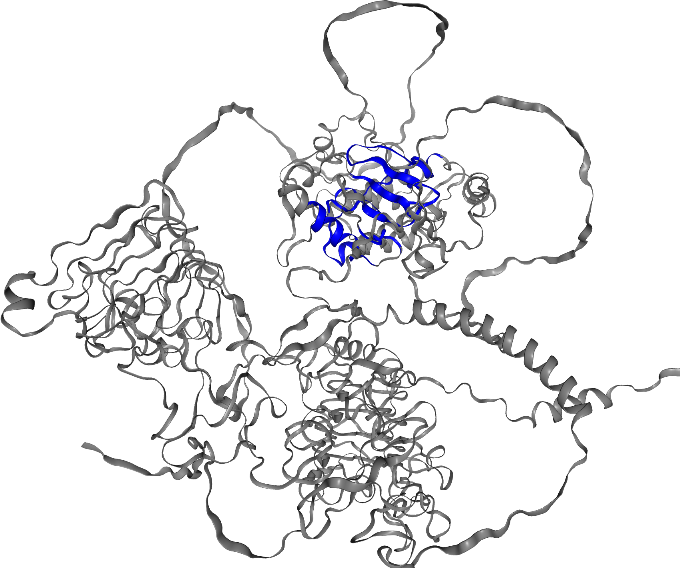

In [26]:
view._display_image()